# Install required packages

In [1]:
# Install required libraries
!pip install numpy pandas matplotlib tqdm scikit-learn seaborn opencv-python tensorflow
!pip install tf-keras-vis
!pip install lime



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


# Import necessary libraries

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns
from glob import glob
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

2024-09-04 23:06:13.957664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 23:06:13.970559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 23:06:13.974384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 23:06:13.985255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Import warnings and suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Optional: Suppress TensorFlow deprecation warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


# Data Loading and Assigning Class Labels

In [4]:

# Data Loading and Label Assignment
train_dir = 'MURA-v1.1/train'
valid_dir = 'MURA-v1.1/valid'
category = 'XR_SHOULDER'

train_data = []
train_labels = []
valid_data = []
valid_labels = []

for label in ['negative', 'positive']:
    # Train data loading
    train_path = os.path.join(train_dir, category)
    train_file_paths = glob(os.path.join(train_path, '**', f'*_{label}'), recursive=True)
    for file_path in train_file_paths:
        for img in glob(os.path.join(file_path, '*.png')):
            train_data.append(img)
            train_labels.append(0 if label == 'negative' else 1)
    
    # Validation data loading
    valid_path = os.path.join(valid_dir, category)
    valid_file_paths = glob(os.path.join(valid_path, '**', f'*_{label}'), recursive=True)
    for file_path in valid_file_paths:
        for img in glob(os.path.join(file_path, '*.png')):
            valid_data.append(img)
            valid_labels.append(0 if label == 'negative' else 1)

# Convert to DataFrames
train_df = pd.DataFrame({'image_path': train_data, 'label': train_labels})
valid_df = pd.DataFrame({'image_path': valid_data, 'label': valid_labels})


# Data Preprocesssing
## Normalization
## Augmentation
## Resizing
## Generators setup

In [5]:

# Image Loading, Resizing, and Normalization
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Processing train images
for i, data in tqdm(train_df.iterrows(), total=len(train_df)):
    img = cv2.imread(data['image_path'])
    img = cv2.resize(img, (224, 224))
    train_images.append(img)
    train_labels.append(data['label'])

train_images = np.asarray(train_images).astype('float32')
train_labels = np.asarray(train_labels)

# Processing validation images
for i, data in tqdm(valid_df.iterrows(), total=len(valid_df)):
    img = cv2.imread(data['image_path'])
    img = cv2.resize(img, (224, 224))
    valid_images.append(img)
    valid_labels.append(data['label'])

valid_images = np.asarray(valid_images).astype('float32')
valid_labels = np.asarray(valid_labels)

# Normalization
mean = np.mean(train_images, axis=(0, 1, 2))
std = np.std(train_images, axis=(0, 1, 2))
train_images = (train_images - mean) / std
valid_images = (valid_images - mean) / std  # Normalize with the same mean and std



100%|██████████| 563/563 [00:01<00:00, 516.02it/s]


In [6]:
# Data Augmentation and Generators Setup
# Converting the labels to strings ('0' -> 'negative', '1' -> 'positive')
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)


Found 8379 validated image filenames belonging to 2 classes.
Found 563 validated image filenames belonging to 2 classes.


## Class Weights Balancing

In [7]:
# Calculate Class Weights for Imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 0.9948943243885063, 1: 1.005158349328215}


# Model Building : DenseNet169

### Fine-tune the layers
### Compiled the model based on optimizer with learning rate, binary_crossentropy and evaluation metric as accuracy
### Defined the callbacks for saving best model and regulating or optimizing the model

In [8]:

# Model Building: DenseNet169
input_shape = (224, 224, 3)
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

# Fine-tuning the last 100 layers
for layer in base_model.layers[-100:]:
    layer.trainable = True

x = base_model.output
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Model Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_path = 'best_model_densenet_shoulder.keras'
# Callbacks Setup
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.0001, verbose=1)
]


2024-09-04 23:07:28.494795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9


# Model Training

In [9]:

# Model Training
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Epoch 1/5


I0000 00:00:1725491296.796703     753 service.cc:146] XLA service 0x7d1de8005730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725491296.796754     753 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-04 23:08:18.424649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 23:08:24.390222: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-09-04 23:10:08.566119: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion', 272 bytes spill stores, 272 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_117', 24 bytes spill stores, 24 bytes spill loads
ptx

 299/1048 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.6277 - loss: 0.6781 - mse: 0.2362

2024-09-04 23:12:25.861796: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion', 272 bytes spill stores, 272 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_121', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_120', 36 bytes spill stores, 36 bytes spill loads



1048/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6561 - loss: 0.6431 - mse: 0.2215
Epoch 1: val_loss improved from inf to 0.54412, saving model to best_model_densenet_shoulder.keras
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 358s 191ms/step - accuracy: 0.6562 - loss: 0.6431 - mse: 0.2215 - val_accuracy: 0.7425 - val_loss: 0.5441 - val_mse: 0.1789 - learning_rate: 1.0000e-04
Epoch 2/5
1047/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7271 - loss: 0.5477 - mse: 0.1832
Epoch 2: val_loss did not improve from 0.54412
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 69s 65ms/step - accuracy: 0.7271 - loss: 0.5477 - mse: 0.1832 - val_accuracy: 0.7353 - val_loss: 0.5529 - val_mse: 0.1864 - learning_rate: 1.0000e-04
Epoch 3/5
1047/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7570 - loss: 0.5168 - mse: 0.1695
Epoch 3: val_loss improved from 0.54412 to 0.51883, saving model to best_model_densenet_shoulder.keras
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 71s 67ms/step - accuracy: 0.7570 - loss: 0.5168 - mse: 0.16

# Model Performance and Evaluation

## Plotting Model Training History (Accuracy and Loss)


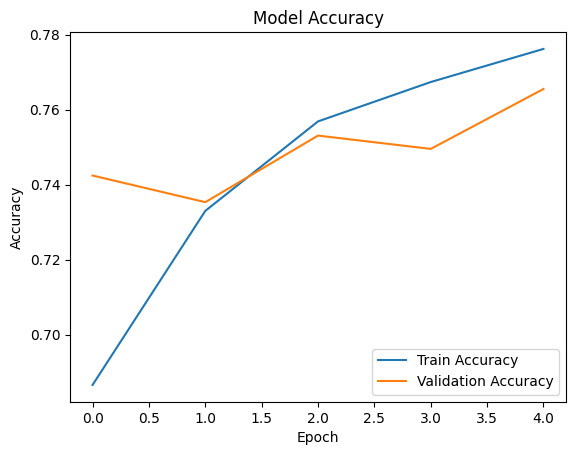

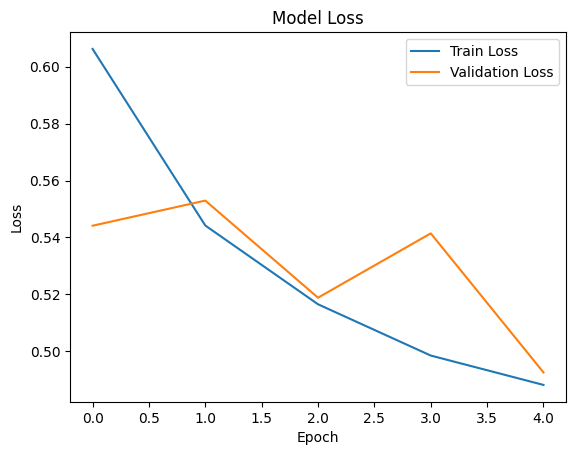

In [10]:

# Accuracy Plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Loss Plot
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## Loading the Best model and Evaluating based on the predictions accuracy on validation set

In [11]:
# Loading the Best Model 
best_model = load_model(checkpoint_path)

In [12]:
# Evaluating the model on the validation set
valid_loss, valid_accuracy = best_model.evaluate(valid_generator)
print(f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")

# Predictions on the validation set
valid_predictions = best_model.predict(valid_generator)
valid_pred_labels = (valid_predictions > 0.5).astype(int)  # Threshold at 0.5


71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.6925 - loss: 0.5984 - mse: 0.2029
Validation Loss: 0.4925847053527832, Validation Accuracy: 0.7655417323112488, Validation MSE: 0.16226358711719513
71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step


## Classification Report
## Confusion Matrix 

### based on the prediction label and true label accuracy

Confusion Matrix:
 [[193  92]
 [ 40 238]]


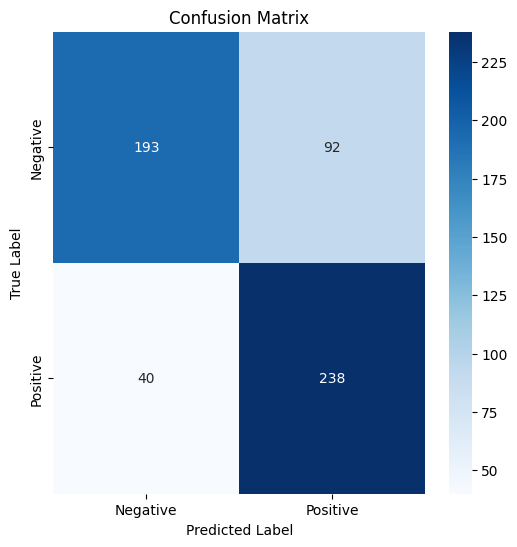

Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.68      0.75       285
    Positive       0.72      0.86      0.78       278

    accuracy                           0.77       563
   macro avg       0.77      0.77      0.76       563
weighted avg       0.78      0.77      0.76       563



In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(valid_generator.classes, valid_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
class_report = classification_report(valid_generator.classes, valid_pred_labels, target_names=['Negative', 'Positive'])
print("Classification Report:\n", class_report)



## ROC and AUC curve

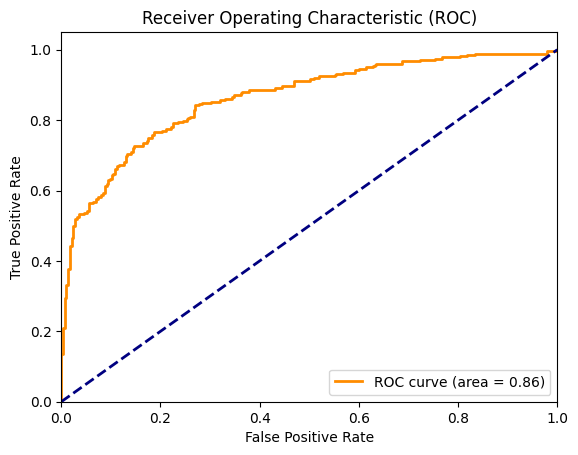

In [14]:
# ROC and AUC Curve
fpr, tpr, _ = roc_curve(valid_generator.classes, valid_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



# Model Building : Resnet50

### Fine-tune the layers
### Compiled the model based on optimizer with learning rate, binary_crossentropy and evaluation metric as accuracy
### Defined the callbacks for saving best model and regulating or optimizing the model

In [15]:
# Model Building: ResNet50
input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

# Fine-tuning the last 50 layers for ResNet50
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

x = base_model.output
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Model Compilation for ResNet50
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks Setup (Saving Best Model for ResNet50)
checkpoint_path = 'best_model_shoulder_resnet50.keras'
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.0001, verbose=1)
]


# Model Training

In [16]:

# Model Training with Class Weights for ResNet50
history_resnet50 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  
    callbacks=callbacks,
    class_weight=class_weight_dict  
)


Epoch 1/5
1045/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5452 - loss: 0.7382 - mse: 0.2657
Epoch 1: val_loss improved from inf to 0.67585, saving model to best_model_shoulder_resnet50.keras
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 91s 73ms/step - accuracy: 0.5452 - loss: 0.7381 - mse: 0.2656 - val_accuracy: 0.5542 - val_loss: 0.6759 - val_mse: 0.2436 - learning_rate: 1.0000e-04
Epoch 2/5
1046/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5902 - loss: 0.6694 - mse: 0.2381
Epoch 2: val_loss improved from 0.67585 to 0.63199, saving model to best_model_shoulder_resnet50.keras
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 68s 64ms/step - accuracy: 0.5902 - loss: 0.6693 - mse: 0.2381 - val_accuracy: 0.6394 - val_loss: 0.6320 - val_mse: 0.2212 - learning_rate: 1.0000e-04
Epoch 3/5
1046/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6152 - loss: 0.6498 - mse: 0.2292
Epoch 3: val_loss improved from 0.63199 to 0.62885, saving model to best_model_shoulder_resnet50.keras
1048/1048 ━━━━━━━━━━━━━━━━━

## Loading the Best model and Evaluating based on the predictions accuracy on validation set

In [17]:
# Loading the Best ResNet50 Model
best_model_resnet50 = load_model(checkpoint_path)

In [18]:
# Evaluating the model on the validation set
valid_loss, valid_accuracy = best_model_resnet50.evaluate(valid_generator)
print(f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")

# Predictions on the validation set
valid_predictions = best_model_resnet50.predict(valid_generator)
valid_pred_labels = (valid_predictions > 0.5).astype(int)  # Threshold at 0.5


71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6074 - loss: 0.6848 - mse: 0.2433
Validation Loss: 0.6288526654243469, Validation Accuracy: 0.634103000164032, Validation MSE: 0.22234414517879486
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step


## Classification Report
## Confusion Matrix 

### based on the prediction label and true label accuracy

Confusion Matrix:
 [[161 124]
 [ 82 196]]


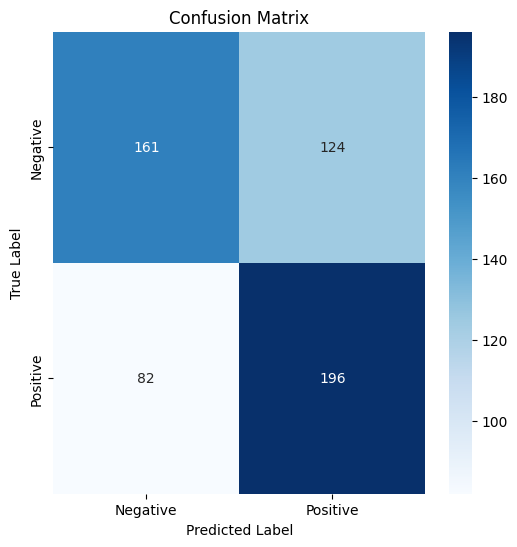

Classification Report:
               precision    recall  f1-score   support

    Negative       0.66      0.56      0.61       285
    Positive       0.61      0.71      0.66       278

    accuracy                           0.63       563
   macro avg       0.64      0.63      0.63       563
weighted avg       0.64      0.63      0.63       563



In [19]:
# Confusion Matrix
conf_matrix = confusion_matrix(valid_generator.classes, valid_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
class_report = classification_report(valid_generator.classes, valid_pred_labels, target_names=['Negative', 'Positive'])
print("Classification Report:\n", class_report)


## ROC and AUC curve

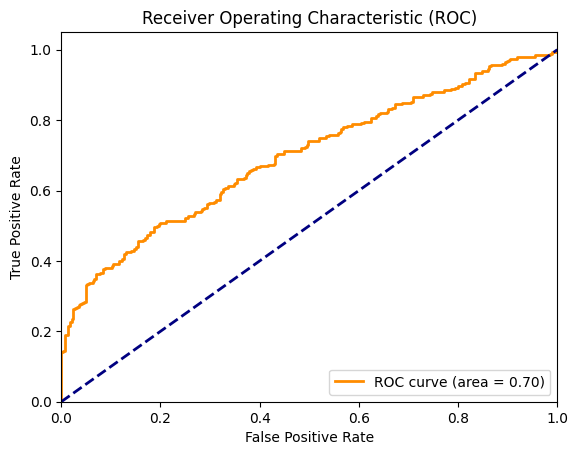

In [20]:
# ROC and AUC Curve
fpr, tpr, _ = roc_curve(valid_generator.classes, valid_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Model Building : InceptionV3

### Fine-tune the layers
### Compiled the model based on optimizer with learning rate, binary_crossentropy and evaluation metric as accuracy
### Defined the callbacks for saving best model and regulating or optimizing the model

In [21]:

# Model Building: InceptionV3
input_shape = (224, 224, 3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

# Fine-tuning the last 100 layers for InceptionV3
for layer in base_model.layers[:-100]:
    layer.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

x = base_model.output
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Model Compilation for InceptionV3
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks Setup (Saving Best Model for InceptionV3)
checkpoint_path = 'best_model_shoulder_inceptionv3.keras'
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.0001, verbose=1)
]


# Model Training

In [22]:

# Model Training for InceptionV3
history_inceptionv3 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  
    callbacks=callbacks,
    class_weight=class_weight_dict  
)



Epoch 1/5
1046/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6323 - loss: 0.6382 - mse: 0.2232
Epoch 1: val_loss improved from inf to 0.61057, saving model to best_model_shoulder_inceptionv3.keras
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 94s 73ms/step - accuracy: 0.6324 - loss: 0.6381 - mse: 0.2232 - val_accuracy: 0.6519 - val_loss: 0.6106 - val_mse: 0.2097 - learning_rate: 1.0000e-04
Epoch 2/5
1046/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7213 - loss: 0.5525 - mse: 0.1860
Epoch 2: val_loss improved from 0.61057 to 0.51513, saving model to best_model_shoulder_inceptionv3.keras
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 68s 64ms/step - accuracy: 0.7213 - loss: 0.5525 - mse: 0.1860 - val_accuracy: 0.7371 - val_loss: 0.5151 - val_mse: 0.1701 - learning_rate: 1.0000e-04
Epoch 3/5
1046/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7309 - loss: 0.5292 - mse: 0.1770
Epoch 3: val_loss did not improve from 0.51513
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - accuracy: 0.7310 - loss: 0.529

## Loading the Best model and Evaluating based on the predictions accuracy on validation set

In [23]:
# Load the Best InceptionV3 Model
best_model_inceptionv3 = load_model(checkpoint_path)

In [24]:
# Evaluating the model on the validation set
valid_loss, valid_accuracy = best_model_inceptionv3.evaluate(valid_generator)
print(f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}")

# Predictions on the validation set
valid_predictions = best_model_inceptionv3.predict(valid_generator)
valid_pred_labels = (valid_predictions > 0.5).astype(int)  # Threshold at 0.5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7705 - loss: 0.5189 - mse: 0.1639
Validation Loss: 0.5151270627975464, Validation Accuracy: 0.7371225357055664, Validation MSE: 0.17014381289482117
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step


## Classification Report
## Confusion Matrix 

### based on the prediction label and true label accuracy

Confusion Matrix:
 [[237  48]
 [100 178]]


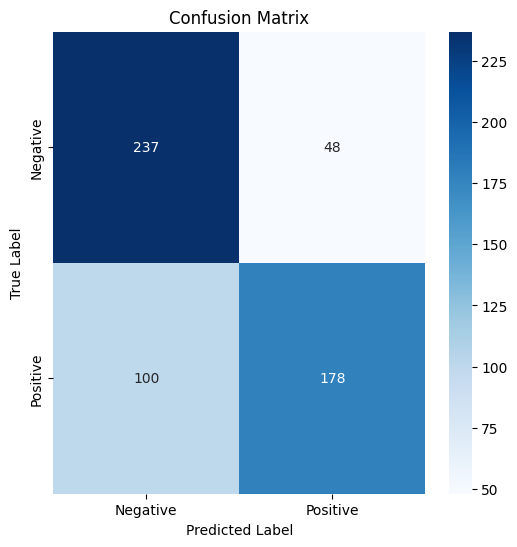

Classification Report:
               precision    recall  f1-score   support

    Negative       0.70      0.83      0.76       285
    Positive       0.79      0.64      0.71       278

    accuracy                           0.74       563
   macro avg       0.75      0.74      0.73       563
weighted avg       0.74      0.74      0.73       563



In [25]:
# Confusion Matrix
conf_matrix = confusion_matrix(valid_generator.classes, valid_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
class_report = classification_report(valid_generator.classes, valid_pred_labels, target_names=['Negative', 'Positive'])
print("Classification Report:\n", class_report)


## ROC and AUC curve

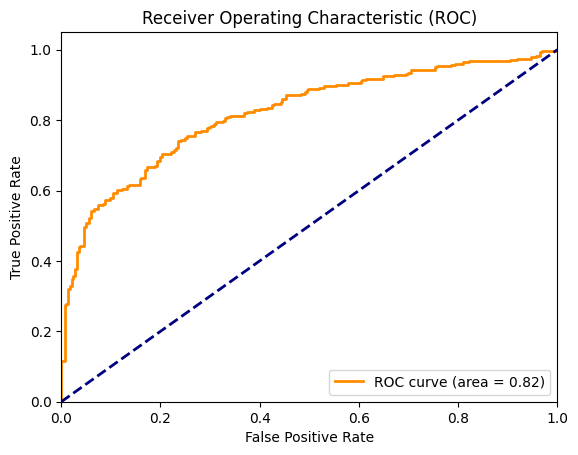

In [26]:
# ROC and AUC Curve
fpr, tpr, _ = roc_curve(valid_generator.classes, valid_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Evaluating Best Model accuracy (DenseNet169)
## Based on matching the prediction and true label on a random image sample size from the validation/test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


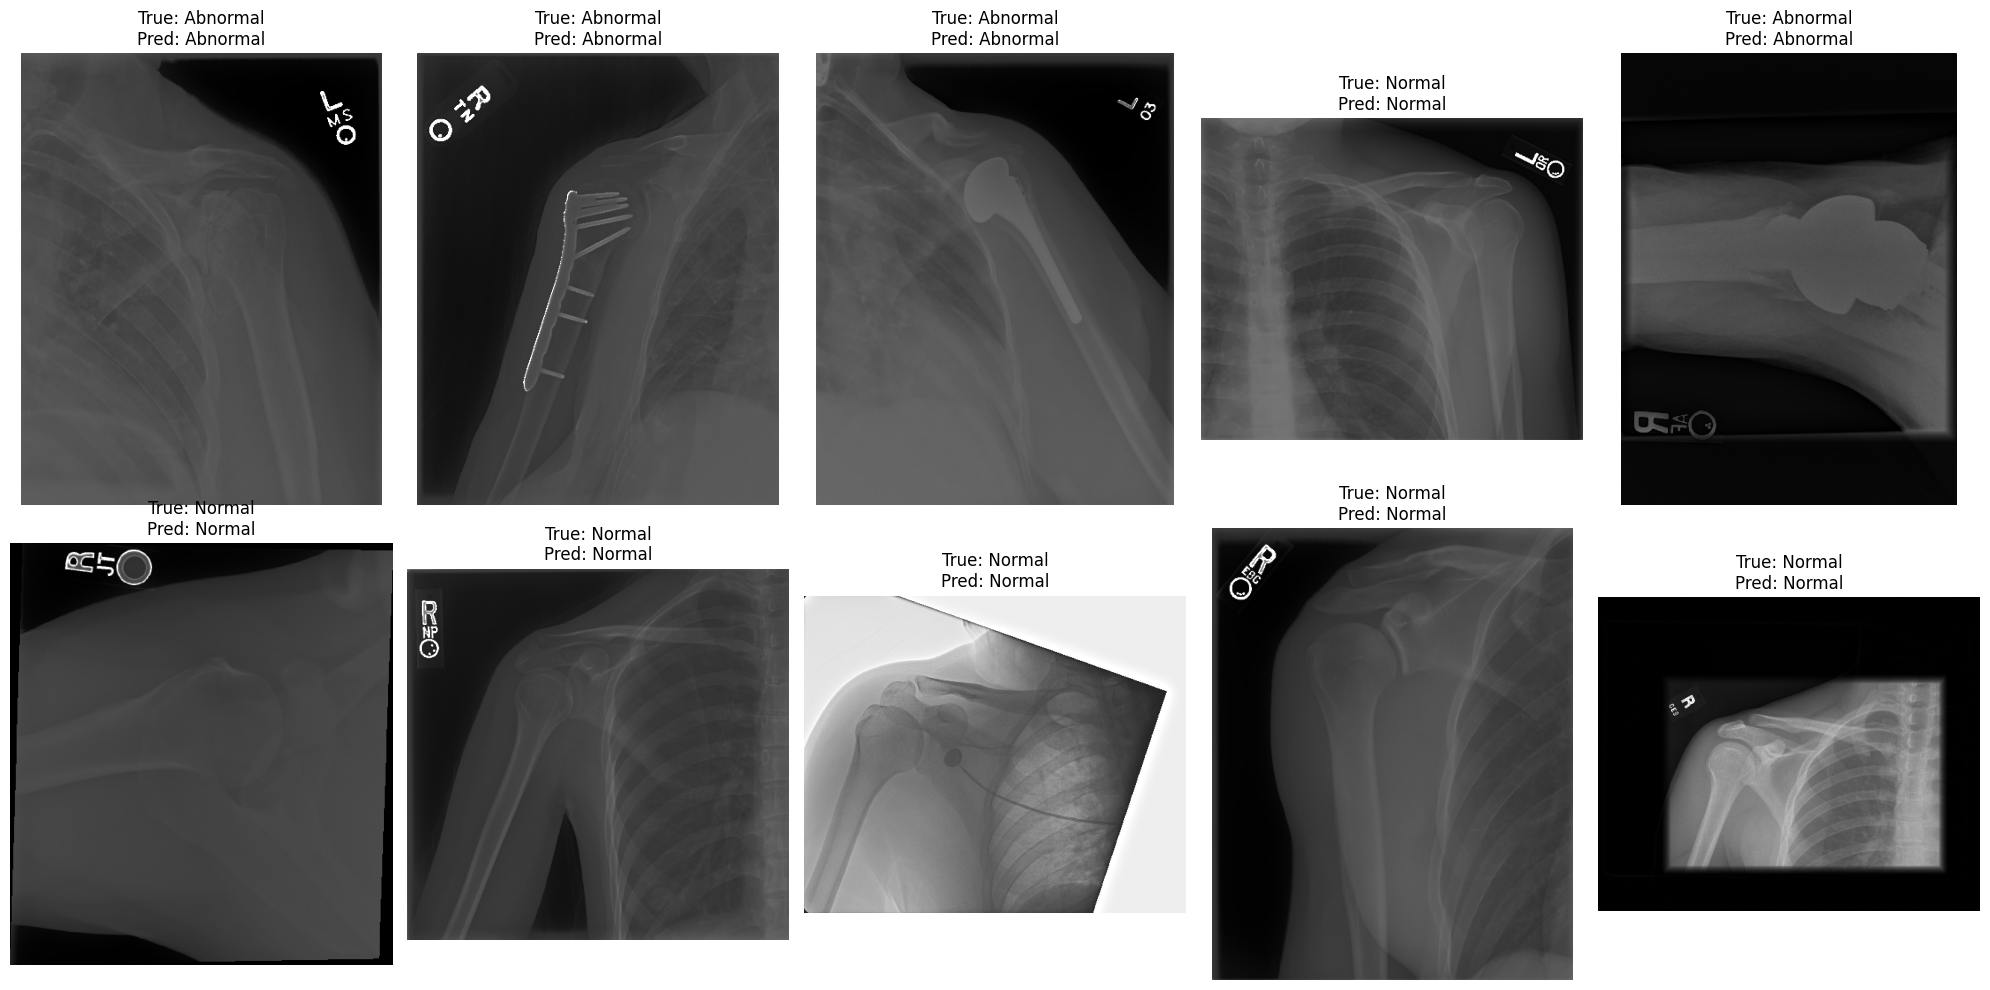

In [15]:


# Loading the best saved best-model
best_model = load_model('best_model_densenet_shoulder.keras')

# Loading the test dataset
test_dir = 'MURA-v1.1/valid'
test_data = []
test_labels = []

for label in ['negative', 'positive']:
    # Test data loading
    test_path = os.path.join(test_dir, category)
    test_file_paths = glob(os.path.join(test_path, '**', f'*_{label}'), recursive=True)
    for file_path in test_file_paths:
        for img in glob(os.path.join(file_path, '*.png')):
            test_data.append(img)
            test_labels.append(0 if label == 'negative' else 1)  # 0 for normal, 1 for abnormal

# Creating DataFrame for test data
test_df = pd.DataFrame({'image_path': test_data, 'label': test_labels})

# Loading and preprocessing image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32')
    img = (img - mean) / std  # Normalize using training mean and std
    return img

# Random 10 images from the test data
random_indices = random.sample(range(len(test_df)), 10)
random_images = test_df.iloc[random_indices]

# Plotting the images with true and predicted labels
plt.figure(figsize=(20, 10))

for i, row in enumerate(random_images.itertuples(), start=1):
    # Preprocess the image
    image_path = row.image_path
    true_label = 'Normal' if row.label == 0 else 'Abnormal'
    img = preprocess_image(image_path)
    
    # Reshaping for prediction
    img_batch = np.expand_dims(img, axis=0)
    
    # Predicting using the best model
    prediction = best_model.predict(img_batch)
    predicted_label = 'Normal' if prediction < 0.5 else 'Abnormal'
    
    # Image display
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Plotting the image
    plt.subplot(2, 5, i)
    plt.imshow(original_img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


# XAI Results on DenseNet169 (best model for prediction)

# 1. LIME


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

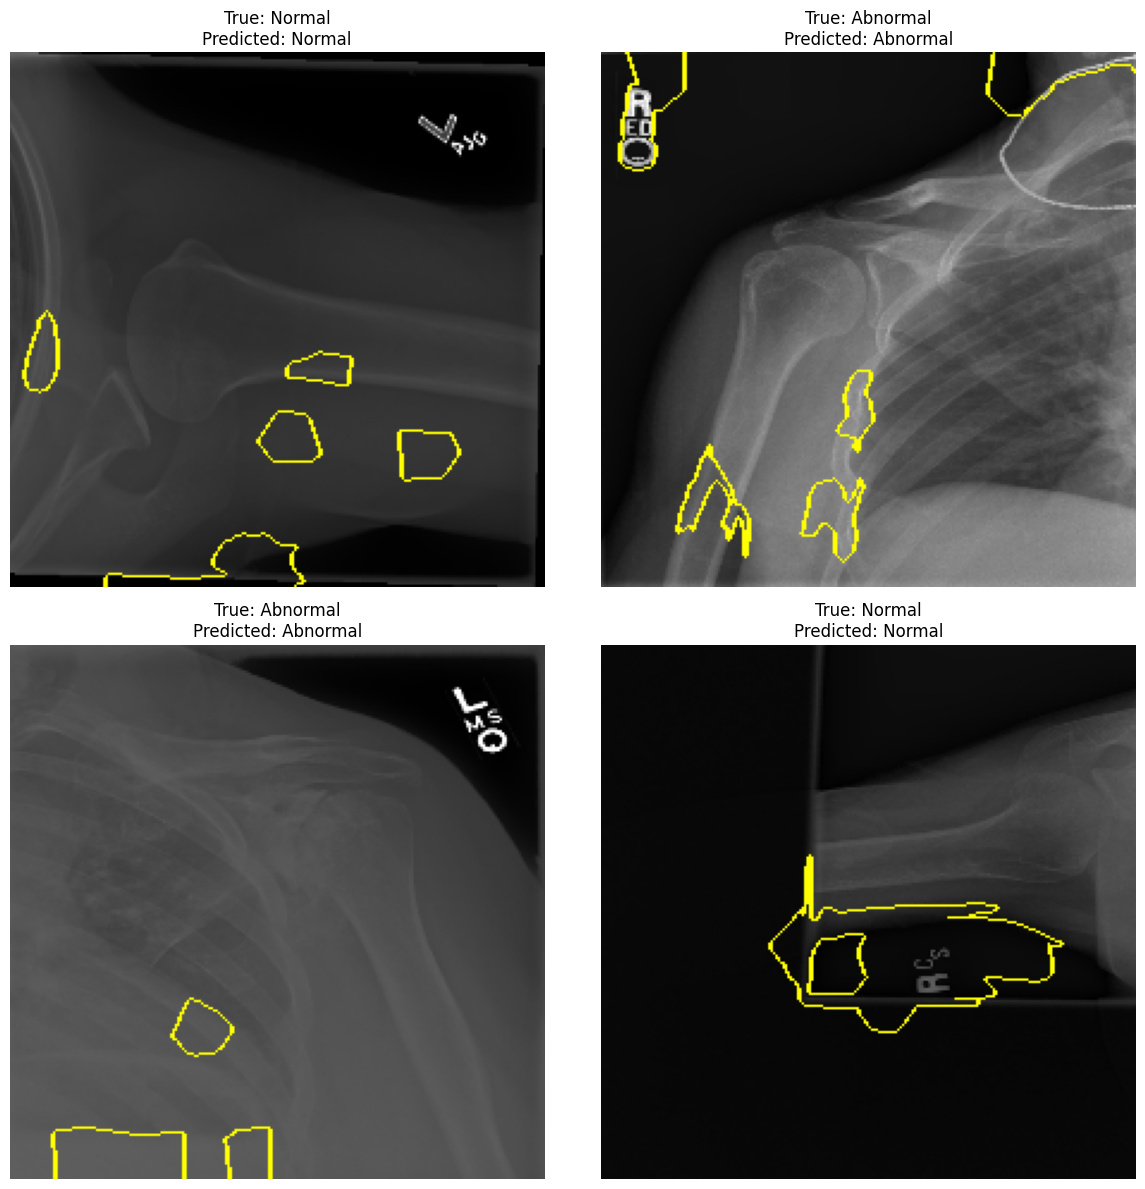

In [16]:

# Preprocessing image for LIME
def preprocess_lime_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize to 224x224 for LIME
    return img / 255.0  # LIME expects input in [0, 1] range

# Predicting function for LIME
def predict_fn(images):
    processed_images = np.array([preprocess_input(img) for img in images])  # Preprocess input for the model
    return best_model.predict(processed_images)

# Custom segmentation function for LIME using SLIC 
def slic_segmentation(image):
    return slic(image, n_segments=150, compactness=5, sigma=1)  # Fewer segments (150), less compact (5) [to increase the area]

# Selecting a sample test set of 4 random images from the test dataset
random_indices = random.sample(range(len(test_df)), 4)

# Displaying the results
plt.figure(figsize=(12, 12))


for i, idx in enumerate(random_indices):
    image_path = test_df.iloc[idx]['image_path']
    true_label = 'Normal' if test_df.iloc[idx]['label'] == 0 else 'Abnormal'
    
    # Preprocessing the image for LIME
    image = preprocess_lime_image(image_path)

    # Using LIME to explain the prediction with the SLIC segmentation
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image, 
        predict_fn, 
        top_labels=2, 
        hide_color=0, 
        num_samples=2000,  # High number of samples for accurate perturbations
        segmentation_fn=slic_segmentation  
    )

    # obtaining the explanation for predicted label
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # retrieving predicted label
    img_for_pred = np.expand_dims(preprocess_input(cv2.resize(cv2.imread(image_path), (224, 224))), axis=0)
    predicted_label = 'Normal' if best_model.predict(img_for_pred) < 0.5 else 'Abnormal'

    # Loading the original image and resizing to match the LIME output
    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  
    original_img_rgb_resized = cv2.resize(original_img_rgb, (224, 224)) 

    # Superimposing the LIME explanation outline on original image
    superimposed_img = mark_boundaries(original_img_rgb_resized / 255.0, mask)

    # Plotting each image with its LIME explanation
    plt.subplot(2, 2, i+1)  
    plt.imshow(superimposed_img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


# 2. Grad-CAM

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


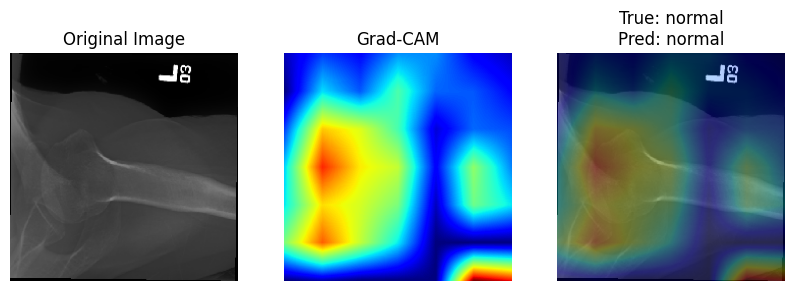

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


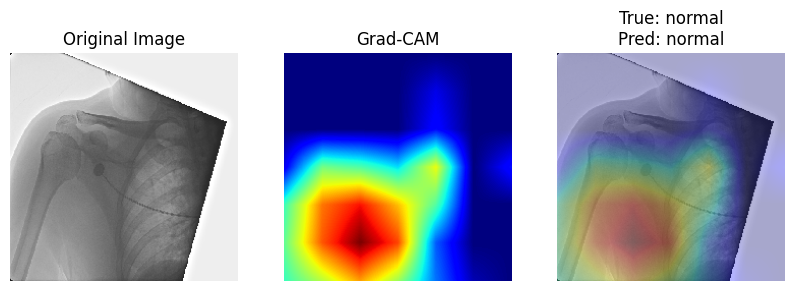

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


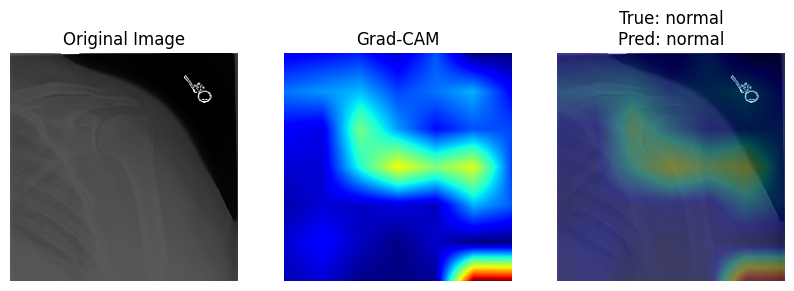

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


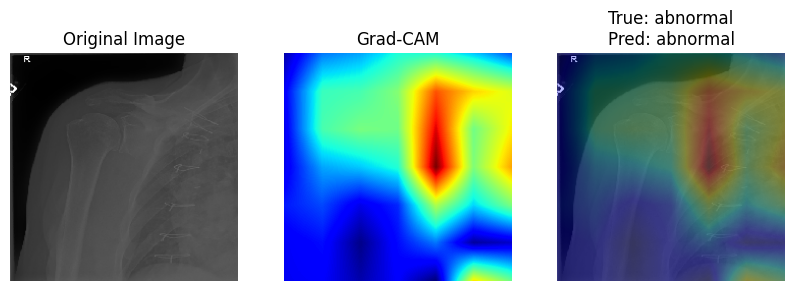

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


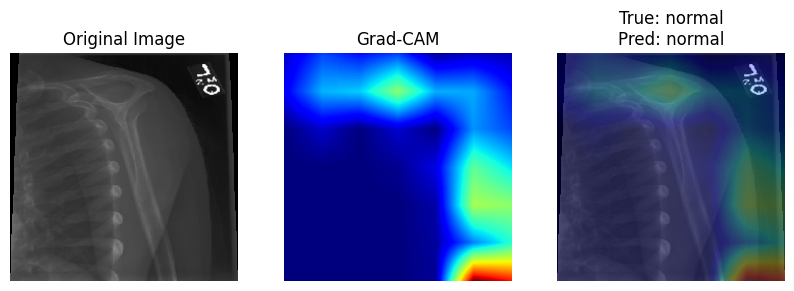

In [18]:


# Loading the best saved DenseNet169 model
model = load_model(checkpoint_path)  

# Modifying the model to replace the final activation with linear for Grad-CAM
replace2linear = ReplaceToLinear()
score = BinaryScore(1)  # label 1 indicates 'abnormal' (since binary classification)

# GradCAM object
gradcam = Gradcam(model, model_modifier=replace2linear, clone=False)


# Generating Grad-CAM visualization (heatmap overlay)
def generate_gradcam_visualization(img_path, model, gradcam, true_label, alpha=0.3):
    # Loading and preprocessing the image
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Generating Grad-CAM heatmap
    cam = gradcam(score, x)
    heatmap = np.uint8(255 * cam[0])

    # model prediction
    prediction = model.predict(x)
    predicted_label = 'abnormal' if prediction > 0.5 else 'normal'

    # Plotting original image, heatmap, and predicted label
    plt.figure(figsize=(10, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    # Grad-CAM heatmap
    plt.subplot(1, 3, 2)
    plt.title('Grad-CAM')
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    # Original Image with Heatmap Overlay
    plt.subplot(1, 3, 3)
    plt.title(f'True: {true_label}\nPred: {predicted_label}')
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)  # light overlay with alpha (it is adjustable)
    plt.axis('off')

    plt.show()

# Sampling 5 random images from validation dataset
random_indices = random.sample(range(len(valid_df)), 5)
selected_images = valid_df.iloc[random_indices]

# Grad-CAM visualizations for sampled images
for i, row in selected_images.iterrows():
    img_path = row['image_path']
    true_label = 'abnormal' if int(row['label']) == 1 else 'normal'
    generate_gradcam_visualization(img_path, model, gradcam, true_label, alpha=0.3) 
